In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
그룹화된 신경망 (Grouped Neural Network) - 전체 파이프라인
============================================================

이 노트북은 청소년 건강 설문 데이터를 위한 해석 가능한 그룹화된 신경망의 
전체 파이프라인을 보여줍니다.

주요 구성요소:
1. 데이터 탐색 및 그룹화
2. 모델 훈련 및 평가
3. 해석성 분석
4. 결과 시각화
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import yaml
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# 프로젝트 모듈 import
sys.path.append('.')
from src.data.dataset import create_data_loaders, GroupedDataset
from src.model.grouped_nn import GroupedNN, create_model_from_config
from src.train import GroupedNNTrainer, MetricsCalculator
from src.interpret.importance import ImportanceAnalyzer, ImportanceVisualizer

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

print("🚀 그룹화된 신경망 파이프라인 시작")
print("=" * 60)
print("✅ 모든 라이브러리 및 모듈 임포트 완료!")
print("📊 한글 폰트 설정 완료!")

⚠️ SHAP 라이브러리가 설치되지 않았습니다. pip install shap으로 설치하세요.
🚀 그룹화된 신경망 파이프라인 시작
✅ 모든 라이브러리 및 모듈 임포트 완료!
📊 한글 폰트 설정 완료!


In [2]:
# data import
df = pd.read_csv('adolescent_health_data.csv')
print(df.head())

       OBS CITY CTYPE CTYPE_SD SCHOOL STYPE   STRATA   STRATA_NM  CLUSTER  \
0  A100001   서울   대도시      대도시    중학교  남녀공학  2024_64  서울대_중학교4_3      1.0   
1  A100002   서울   대도시      대도시    중학교  남녀공학  2024_64  서울대_중학교4_3      1.0   
2  A100003   서울   대도시      대도시    중학교  남녀공학  2024_64  서울대_중학교4_3      1.0   
3  A100004   서울   대도시      대도시    중학교  남녀공학  2024_64  서울대_중학교4_3      1.0   
4  A100005   서울   대도시      대도시    중학교  남녀공학  2024_64  서울대_중학교4_3      1.0   

    GROUP  ...  E_LT_F  E_LT_SF E_LT_M  E_LT_SM E_EDU_F  E_KRN_F  E_BORN_F  \
0  서울대4-3  ...     1.0   9999.0    1.0   9999.0     3.0      1.0    9999.0   
1  서울대4-3  ...     1.0   9999.0    1.0   9999.0     3.0      1.0    9999.0   
2  서울대4-3  ...     1.0   9999.0    1.0   9999.0     3.0      1.0    9999.0   
3  서울대4-3  ...     2.0   9999.0    1.0   9999.0     3.0      1.0    9999.0   
4  서울대4-3  ...     1.0   9999.0    1.0   9999.0     3.0      1.0    9999.0   

   E_EDU_M  E_KRN_M  E_BORN_M  
0      3.0      1.0    9999.0  
1   

# 1. 프로젝트 개요 및 설정

## 🎯 목표
청소년 건강 설문 데이터에서 정신건강 위험도를 예측하는 해석 가능한 그룹화된 신경망을 구축합니다.

## 🔧 주요 특징
- **그룹별 처리**: 서로 다른 특성 그룹(S_, PA_, F_, AC_, TC_ 등)을 각각 처리
- **동적 입력 크기**: 각 그룹마다 다른 수의 특성을 동적으로 처리
- **해석성**: Permutation Importance 및 SHAP을 통한 그룹별 중요도 분석
- **누락 처리**: 누락된 그룹에 대한 학습 가능한 null 임베딩

## 📊 데이터
- **파일**: `adolescent_health_data.csv`
- **타겟**: M_STR (스트레스 수준) → 이진 분류 (4 이상 = 높음)
- **특성 그룹**:
  - S: 사회경제적 요인
  - PA: 신체활동
  - F: 식생활
  - AC: 음주 관련
  - TC: 흡연 관련
  - 기타 그룹들...


In [3]:
# 🔧 설정 및 파라미터
CONFIG = {
    'data': {
        'csv_path': 'adolescent_health_data.csv',
        'groups_yaml': 'src/config/groups.yaml',
        'train_ratio': 0.8,
        'batch_size': 64,
        'random_seed': 42
    },
    'model': {
        'hidden_dim': 64,
        'group_embedding_dim': 32,
        'final_hidden_dims': [128, 64],
        'dropout': 0.1,
        'num_group_layers': 2
    },
    'training': {
        'learning_rate': 0.001,
        'weight_decay': 1e-5,
        'epochs': 50,
        'patience': 15
    },
    'output': {
        'model_dir': 'outputs',
        'plots_dir': 'plots',
        'results_dir': 'results'
    }
}

# 출력 디렉토리 생성
for dir_path in CONFIG['output'].values():
    os.makedirs(dir_path, exist_ok=True)

print("📁 설정 완료:")
for category, settings in CONFIG.items():
    print(f"  {category}: {settings}")

# 랜덤 시드 설정
np.random.seed(CONFIG['data']['random_seed'])
torch.manual_seed(CONFIG['data']['random_seed'])
print(f"\n🎲 랜덤 시드 설정: {CONFIG['data']['random_seed']}")


📁 설정 완료:
  data: {'csv_path': 'adolescent_health_data.csv', 'groups_yaml': 'src/config/groups.yaml', 'train_ratio': 0.8, 'batch_size': 64, 'random_seed': 42}
  model: {'hidden_dim': 64, 'group_embedding_dim': 32, 'final_hidden_dims': [128, 64], 'dropout': 0.1, 'num_group_layers': 2}
  training: {'learning_rate': 0.001, 'weight_decay': 1e-05, 'epochs': 50, 'patience': 15}
  output: {'model_dir': 'outputs', 'plots_dir': 'plots', 'results_dir': 'results'}

🎲 랜덤 시드 설정: 42


# 2. 데이터 로딩 및 탐색

먼저 데이터를 로드하고 기본적인 탐색을 수행합니다.


In [4]:
# 📊 데이터 기본 정보 확인
print("📊 데이터 로딩 및 기본 정보 확인")
print("=" * 50)

# 원본 데이터 로드
df_raw = pd.read_csv(CONFIG['data']['csv_path'])
print(f"원본 데이터 크기: {df_raw.shape}")
print(f"메모리 사용량: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 그룹 설정 로드
with open(CONFIG['data']['groups_yaml'], 'r', encoding='utf-8') as f:
    groups_config = yaml.safe_load(f)

print(f"\n📋 변수 그룹 정보:")
total_features = 0
for group in groups_config['groups']:
    group_features = [f for f in group['features'] if f in df_raw.columns]
    total_features += len(group_features)
    print(f"  {group['name']:8s}: {len(group_features):2d}개 변수 - {group['description']}")

print(f"\n총 사용 변수: {total_features}개 (전체 {df_raw.shape[1]}개 중)")

# 타겟 변수 분포 확인
target_col = groups_config['target']['name']
target_threshold = groups_config['target']['threshold']

if target_col in df_raw.columns:
    target_dist = df_raw[target_col].value_counts().sort_index()
    target_binary = (df_raw[target_col] >= target_threshold).value_counts()
    
    print(f"\n🎯 타겟 변수 ({target_col}) 분포:")
    print(f"원본 분포: {dict(target_dist)}")
    print(f"이진 분포: 낮음(0): {target_binary.get(False, 0)}, 높음(1): {target_binary.get(True, 0)}")
    print(f"높은 스트레스 비율: {target_binary.get(True, 0) / len(df_raw) * 100:.1f}%")
else:
    print(f"⚠️ 타겟 변수 '{target_col}'을 찾을 수 없습니다.")


📊 데이터 로딩 및 기본 정보 확인
원본 데이터 크기: (54653, 195)
메모리 사용량: 124.88 MB

📋 변수 그룹 정보:
  S       :  5개 변수 - 사회경제적 요인
  PA      :  7개 변수 - 신체활동 관련 요인
  F       :  7개 변수 - 식생활 관련 요인
  E       : 22개 변수 - 환경적 요인
  AC      : 27개 변수 - 음주 관련 요인
  TC      : 42개 변수 - 흡연 관련 요인
  I       : 13개 변수 - 부상 관련 요인
  INT     :  4개 변수 - 인터넷 사용 관련 요인
  O       :  8개 변수 - 기타 건강 행동
  HW      :  5개 변수 - 손씻기 관련 요인
  M       : 22개 변수 - 정신건강 관련 요인 (타겟 포함)

총 사용 변수: 162개 (전체 195개 중)

🎯 타겟 변수 (M_STR) 분포:
원본 분포: {1.0: 6140, 2.0: 16902, 3.0: 22963, 4.0: 7061, 5.0: 1587}
이진 분포: 낮음(0): 46005, 높음(1): 8648
높은 스트레스 비율: 15.8%


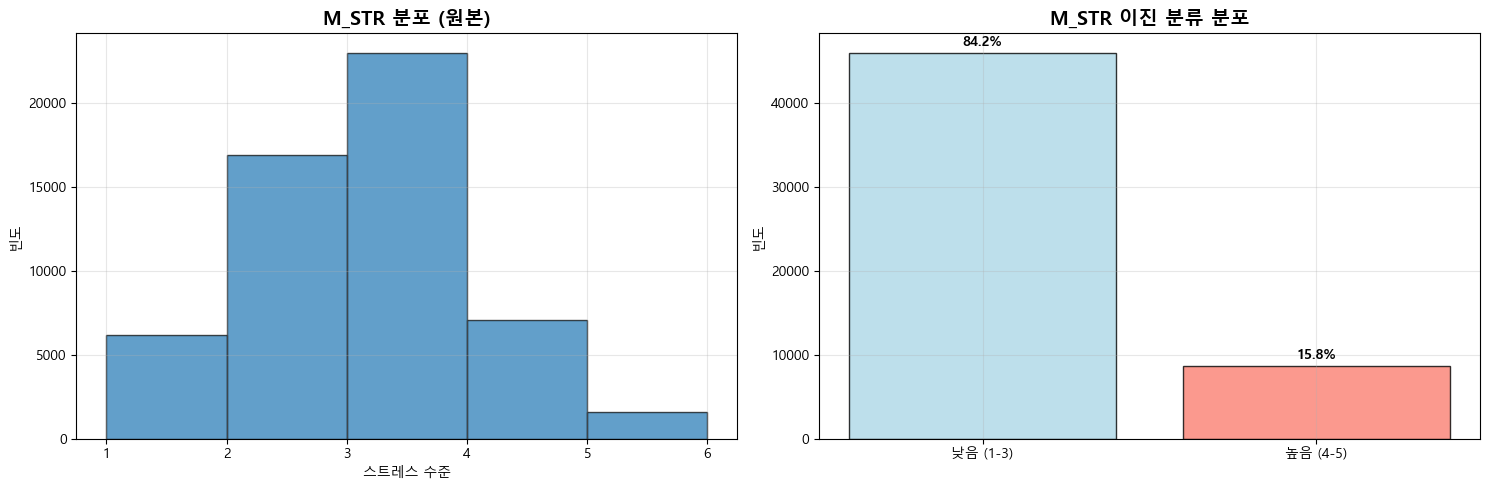

📈 타겟 변수 분포 시각화 완료


In [5]:
# 📊 타겟 변수 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 원본 분포
if target_col in df_raw.columns:
    # 히스토그램
    df_raw[target_col].hist(bins=range(1, 7), alpha=0.7, edgecolor='black', ax=axes[0])
    axes[0].set_title(f'{target_col} 분포 (원본)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('스트레스 수준')
    axes[0].set_ylabel('빈도')
    axes[0].grid(True, alpha=0.3)
    
    # 이진 분류 분포
    binary_labels = ['낮음 (1-3)', '높음 (4-5)']
    binary_counts = [target_binary.get(False, 0), target_binary.get(True, 0)]
    colors = ['lightblue', 'salmon']
    
    axes[1].bar(binary_labels, binary_counts, color=colors, alpha=0.8, edgecolor='black')
    axes[1].set_title(f'{target_col} 이진 분류 분포', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('빈도')
    
    # 퍼센티지 표시
    for i, count in enumerate(binary_counts):
        percentage = count / sum(binary_counts) * 100
        axes[1].text(i, count + 500, f'{percentage:.1f}%', 
                    ha='center', va='bottom', fontweight='bold')
    
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CONFIG['output']['plots_dir']}/target_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print("📈 타겟 변수 분포 시각화 완료")


# 3. 데이터 전처리 및 로더 생성

그룹화된 데이터셋을 생성하고 훈련/검증 데이터로더를 만듭니다.


In [6]:
# 🔄 데이터로더 생성
print("🔄 그룹화된 데이터로더 생성")
print("=" * 40)

try:
    # 데이터로더 생성
    train_loader, val_loader, group_dimensions = create_data_loaders(
        csv_path=CONFIG['data']['csv_path'],
        groups_yaml_path=CONFIG['data']['groups_yaml'],
        train_ratio=CONFIG['data']['train_ratio'],
        batch_size=CONFIG['data']['batch_size'],
        random_seed=CONFIG['data']['random_seed']
    )
    
    print("✅ 데이터로더 생성 성공!")
    print(f"\n📊 데이터 분할:")
    print(f"  훈련 샘플: {len(train_loader.dataset):,}개")
    print(f"  검증 샘플: {len(val_loader.dataset):,}개")
    print(f"  배치 크기: {CONFIG['data']['batch_size']}")
    print(f"  훈련 배치 수: {len(train_loader)}")
    print(f"  검증 배치 수: {len(val_loader)}")
    
    print(f"\n🔍 그룹별 차원:")
    for group_name, dim in group_dimensions.items():
        print(f"  {group_name:8s}: {dim:2d}차원")
    
    # 첫 번째 배치 확인
    print(f"\n🔬 첫 번째 배치 확인:")
    for x_groups, y in train_loader:
        print(f"  그룹별 텐서 크기:")
        for name, tensor in x_groups.items():
            print(f"    {name:8s}: {list(tensor.shape)}")
        print(f"  타겟 크기: {list(y.shape)}")
        print(f"  타겟 분포: {torch.unique(y, return_counts=True)}")
        break
        
except Exception as e:
    print(f"❌ 데이터로더 생성 실패: {str(e)}")
    raise


🔄 그룹화된 데이터로더 생성
✅ 설정 로드 완료: 11개 그룹
✅ 데이터 로드 완료: (54653, 195)
📊 선택된 컬럼 수: 162
📊 타겟 분포: (array([0, 1]), array([46005,  8648], dtype=int64))
✅ 전처리 완료: 10개 그룹
✅ 데이터로더 생성 완료:
   훈련: 43722개 샘플
   검증: 10931개 샘플
   그룹 차원: {'S': 5, 'PA': 7, 'F': 7, 'E': 22, 'AC': 27, 'TC': 42, 'I': 13, 'INT': 4, 'O': 8, 'HW': 5}
✅ 데이터로더 생성 성공!

📊 데이터 분할:
  훈련 샘플: 43,722개
  검증 샘플: 10,931개
  배치 크기: 64
  훈련 배치 수: 684
  검증 배치 수: 171

🔍 그룹별 차원:
  S       :  5차원
  PA      :  7차원
  F       :  7차원
  E       : 22차원
  AC      : 27차원
  TC      : 42차원
  I       : 13차원
  INT     :  4차원
  O       :  8차원
  HW      :  5차원

🔬 첫 번째 배치 확인:
  그룹별 텐서 크기:
    S       : [64, 5]
    PA      : [64, 7]
    F       : [64, 7]
    E       : [64, 22]
    AC      : [64, 27]
    TC      : [64, 42]
    I       : [64, 13]
    INT     : [64, 4]
    O       : [64, 8]
    HW      : [64, 5]
  타겟 크기: [64, 1]
  타겟 분포: (tensor([0., 1.]), tensor([60,  4]))


# 4. 모델 생성 및 구조 확인

그룹화된 신경망 모델을 생성하고 구조를 확인합니다.


In [7]:
# 🧠 모델 생성
print("🧠 그룹화된 신경망 모델 생성")
print("=" * 40)

# 모델 생성
model = create_model_from_config(
    group_dimensions=group_dimensions,
    groups_yaml_path=CONFIG['data']['groups_yaml'],
    model_config=CONFIG['model']
)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"📱 디바이스: {device}")

# 모델 구조 정보
print(f"\n📋 모델 구조 정보:")
summary = model.get_group_embedding_summary()
print(f"  총 파라미터: {model.count_parameters():,}개")
print(f"  그룹 수: {len(model.group_names)}")

print(f"\n🔍 그룹별 서브넷 정보:")
for group_name, info in summary.items():
    print(f"  {group_name:8s}: {info['input_dim']:2d} → {info['output_dim']:2d} "
          f"({info['parameters']:,} params) - {info['description'][:30]}")

# 순전파 테스트
print(f"\n🔬 순전파 테스트:")
model.eval()
with torch.no_grad():
    for x_groups, y in train_loader:
        # 데이터를 디바이스로 이동
        x_groups_device = {name: tensor.to(device) for name, tensor in x_groups.items()}
        
        # 순전파
        outputs = model(x_groups_device)
        probs = model.predict_proba(x_groups_device)
        contributions = model.get_group_contributions(x_groups_device)
        
        print(f"  입력 배치: {len(x_groups_device)}개 그룹")
        print(f"  출력 크기: {list(outputs.shape)}")
        print(f"  확률 범위: [{probs.min().item():.3f}, {probs.max().item():.3f}]")
        print(f"  그룹별 기여도 (평균):")
        for name, contrib in contributions.items():
            print(f"    {name:8s}: {contrib.mean().item():.4f}")
        break

print("\n✅ 모델 생성 및 테스트 완료!")


🧠 그룹화된 신경망 모델 생성
✅ GroupedNN 모델 생성 완료:
   그룹 수: 10
   그룹별 차원: {'S': 5, 'PA': 7, 'F': 7, 'E': 22, 'AC': 27, 'TC': 42, 'I': 13, 'INT': 4, 'O': 8, 'HW': 5}
   그룹 임베딩 차원: 32
   총 파라미터 수: 121,729
📱 디바이스: cpu

📋 모델 구조 정보:
  총 파라미터: 121,729개
  그룹 수: 10

🔍 그룹별 서브넷 정보:
  S       :  5 → 32 (6,624 params) - 사회경제적 요인
  PA      :  7 → 32 (6,752 params) - 신체활동 관련 요인
  F       :  7 → 32 (6,752 params) - 식생활 관련 요인
  E       : 22 → 32 (7,712 params) - 환경적 요인
  AC      : 27 → 32 (8,032 params) - 음주 관련 요인
  TC      : 42 → 32 (8,992 params) - 흡연 관련 요인
  I       : 13 → 32 (7,136 params) - 부상 관련 요인
  INT     :  4 → 32 (6,560 params) - 인터넷 사용 관련 요인
  O       :  8 → 32 (6,816 params) - 기타 건강 행동
  HW      :  5 → 32 (6,624 params) - 손씻기 관련 요인

🔬 순전파 테스트:
  입력 배치: 10개 그룹
  출력 크기: [64, 1]
  확률 범위: [0.328, 0.507]
  그룹별 기여도 (평균):
    S       : 0.5614
    PA      : 1.3218
    F       : 1.2147
    E       : 1.3614
    AC      : 1.7566
    TC      : 1.5271
    I       : 1.2904
    INT     : 0.7649
    O       : 1.6203

# 5. 모델 훈련

이제 모델을 훈련하고 성능을 모니터링합니다.


In [8]:
# 🚀 모델 훈련 시작
print("🚀 모델 훈련 시작")
print("=" * 50)

# 훈련기 생성
trainer = GroupedNNTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    learning_rate=CONFIG['training']['learning_rate'],
    weight_decay=CONFIG['training']['weight_decay']
)

# 훈련 실행
model_save_path = os.path.join(CONFIG['output']['model_dir'], 'best_grouped_nn.pth')

training_history = trainer.train(
    epochs=CONFIG['training']['epochs'],
    early_stopping_patience=CONFIG['training']['patience'],
    save_best_model=True,
    model_save_path=model_save_path,
    verbose=1
)

print(f"\n📈 훈련 완료!")
print(f"💾 최고 모델 저장: {model_save_path}")

# 최종 성능 출력
train_hist = training_history['train_history']
val_hist = training_history['val_history']

print(f"\n📊 최종 성능:")
print(f"  최고 훈련 AUROC: {max(train_hist['auroc']):.4f}")
print(f"  최고 검증 AUROC: {max(val_hist['auroc']):.4f}")
print(f"  최고 훈련 AUPRC: {max(train_hist['auprc']):.4f}")
print(f"  최고 검증 AUPRC: {max(val_hist['auprc']):.4f}")
print(f"  최고 훈련 F1: {max(train_hist['f1']):.4f}")
print(f"  최고 검증 F1: {max(val_hist['f1']):.4f}")


🚀 모델 훈련 시작
✅ 훈련기 초기화 완료:
   디바이스: cpu
   학습률: 0.001
   가중치 감쇠: 1e-05

🚀 훈련 시작: 50 에포크
✅ 모델 저장 완료: outputs\best_grouped_nn.pth
Epoch   1/50 | 시간: 23.8s | Train Loss: 0.4257 | Val Loss: 0.4015 | Val AUROC: 0.6793 | Val AUPRC: 0.2670 | Val F1: 0.0000
✅ 모델 저장 완료: outputs\best_grouped_nn.pth
Epoch   2/50 | 시간: 14.9s | Train Loss: 0.4176 | Val Loss: 0.4028 | Val AUROC: 0.6821 | Val AUPRC: 0.2680 | Val F1: 0.0000
Epoch   3/50 | 시간: 16.0s | Train Loss: 0.4152 | Val Loss: 0.4135 | Val AUROC: 0.6798 | Val AUPRC: 0.2651 | Val F1: 0.0000
✅ 모델 저장 완료: outputs\best_grouped_nn.pth
Epoch   4/50 | 시간: 15.1s | Train Loss: 0.4147 | Val Loss: 0.4008 | Val AUROC: 0.6799 | Val AUPRC: 0.2723 | Val F1: 0.0072
Epoch   5/50 | 시간: 15.3s | Train Loss: 0.4128 | Val Loss: 0.4031 | Val AUROC: 0.6810 | Val AUPRC: 0.2708 | Val F1: 0.0316
Epoch   6/50 | 시간: 17.2s | Train Loss: 0.4117 | Val Loss: 0.3992 | Val AUROC: 0.6846 | Val AUPRC: 0.2694 | Val F1: 0.0084
✅ 모델 저장 완료: outputs\best_grouped_nn.pth
Epoch   7/50 | 시간: 19.


📈 훈련 과정 시각화
📊 훈련 그래프 저장: plots\training_progress.png


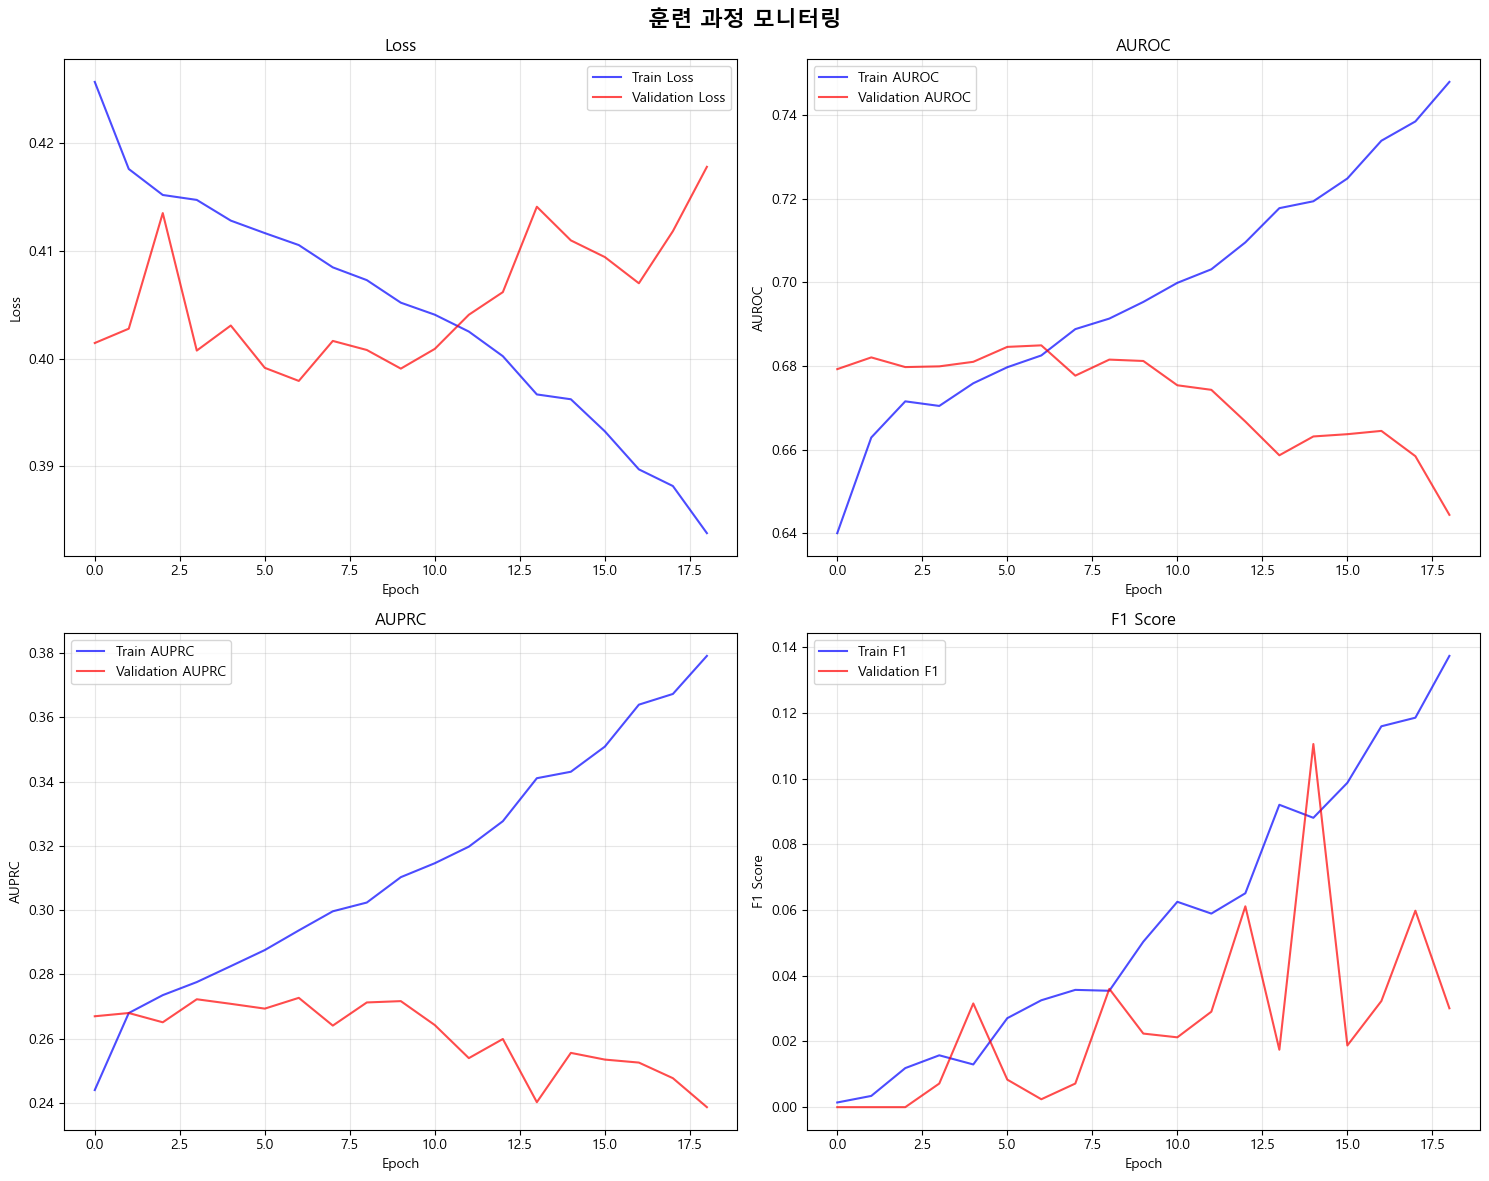

💾 훈련 그래프 저장: plots\training_progress.png


In [9]:
# 📈 훈련 과정 시각화
print("\n📈 훈련 과정 시각화")

# 훈련 그래프 생성
plot_path = os.path.join(CONFIG['output']['plots_dir'], 'training_progress.png')
MetricsCalculator.plot_metrics(
    train_history=train_hist,
    val_history=val_hist,
    save_path=plot_path
)

print(f"💾 훈련 그래프 저장: {plot_path}")


# 6. 해석성 분석

훈련된 모델의 그룹별 중요도를 분석합니다.


🔍 그룹별 중요도 분석 시작
✅ GroupedNN 모델 생성 완료:
   그룹 수: 10
   그룹별 차원: {'S': 5, 'PA': 7, 'F': 7, 'E': 22, 'AC': 27, 'TC': 42, 'I': 13, 'INT': 4, 'O': 8, 'HW': 5}
   그룹 임베딩 차원: 32
   총 파라미터 수: 121,729
✅ 모델 로드 완료: outputs\best_grouped_nn.pth
🚀 전체 중요도 분석 시작

1️⃣ Permutation Importance 분석
🔍 그룹별 중요도 계산 시작 (auroc 기준)
📊 기준 AUROC: 0.6850
🔄 S 그룹 처리 중...
   중요도: -0.0001 ± 0.0006
🔄 PA 그룹 처리 중...
   중요도: 0.0329 ± 0.0028
🔄 F 그룹 처리 중...
   중요도: 0.0311 ± 0.0035
🔄 E 그룹 처리 중...
   중요도: 0.0057 ± 0.0014
🔄 AC 그룹 처리 중...
   중요도: 0.0290 ± 0.0033
🔄 TC 그룹 처리 중...
   중요도: 0.0073 ± 0.0016
🔄 I 그룹 처리 중...
   중요도: 0.0110 ± 0.0016
🔄 INT 그룹 처리 중...
   중요도: 0.0032 ± 0.0008
🔄 O 그룹 처리 중...
   중요도: 0.0154 ± 0.0022
🔄 HW 그룹 처리 중...
   중요도: 0.0005 ± 0.0002
💾 결과 저장: results\importance_results.json

3️⃣ 시각화 생성
📊 중요도 그래프 저장: results\group_importance.png


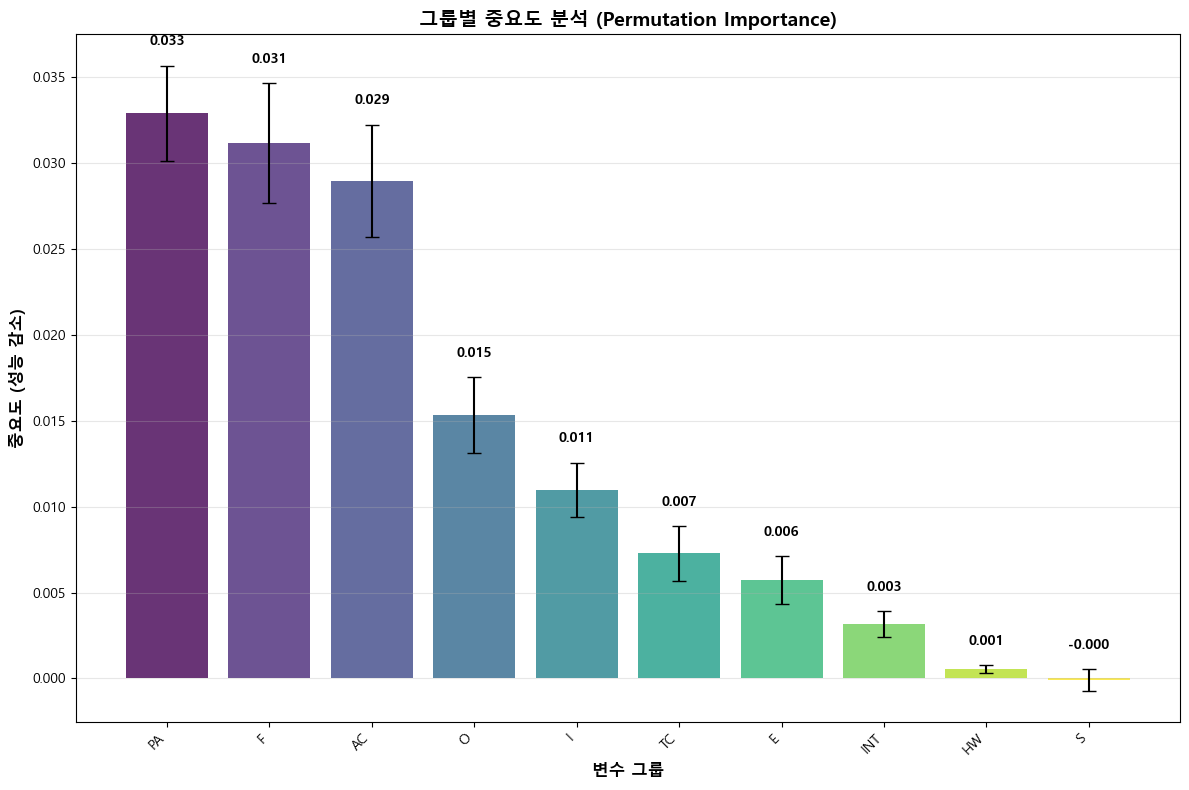

📄 요약 보고서 저장: results\importance_summary.txt
✅ 중요도 분석 완료!

✅ 해석성 분석 완료!

📊 그룹별 중요도 순위 (Permutation Importance):
 1. PA      :  0.0329 ± 0.0028 (상대적:   4.8%)
 2. F       :  0.0311 ± 0.0035 (상대적:   4.5%)
 3. AC      :  0.0290 ± 0.0033 (상대적:   4.2%)
 4. O       :  0.0154 ± 0.0022 (상대적:   2.2%)
 5. I       :  0.0110 ± 0.0016 (상대적:   1.6%)
 6. TC      :  0.0073 ± 0.0016 (상대적:   1.1%)
 7. E       :  0.0057 ± 0.0014 (상대적:   0.8%)
 8. INT     :  0.0032 ± 0.0008 (상대적:   0.5%)
 9. HW      :  0.0005 ± 0.0002 (상대적:   0.1%)
10. S       : -0.0001 ± 0.0006 (상대적:  -0.0%)


In [10]:
# 🔍 해석성 분석 시작
print("🔍 그룹별 중요도 분석 시작")
print("=" * 50)

# 최고 모델 로드
best_model = GroupedNN.load_model(model_save_path, CONFIG['data']['groups_yaml'])
best_model.to(device)

# 중요도 분석기 생성
analyzer = ImportanceAnalyzer(
    model=best_model,
    device=device,
    use_shap=False  # SHAP은 시간이 오래 걸리므로 선택적으로
)

# 전체 중요도 분석 수행
importance_results = analyzer.analyze_full_importance(
    data_loader=val_loader,
    output_dir=CONFIG['output']['results_dir'],
    save_plots=True
)

print("\n✅ 해석성 분석 완료!")

# 결과 요약 출력
perm_results = importance_results['permutation_importance']
print(f"\n📊 그룹별 중요도 순위 (Permutation Importance):")
sorted_groups = sorted(
    perm_results.keys(), 
    key=lambda x: perm_results[x]['importance'], 
    reverse=True
)

for i, group in enumerate(sorted_groups, 1):
    importance = perm_results[group]['importance']
    std = perm_results[group]['importance_std']
    relative = perm_results[group]['relative_importance']
    
    print(f"{i:2d}. {group:8s}: {importance:7.4f} ± {std:6.4f} "
          f"(상대적: {relative:6.1%})")


# 7. 결과 요약 및 결론


In [11]:
# 📋 최종 결과 요약
print("📋 그룹화된 신경망 최종 결과 요약")
print("=" * 60)

# 모델 성능
best_auroc = max(val_hist['auroc'])
best_auprc = max(val_hist['auprc'])
best_f1 = max(val_hist['f1'])

print(f"🎯 모델 성능:")
print(f"  최고 검증 AUROC: {best_auroc:.4f}")
print(f"  최고 검증 AUPRC: {best_auprc:.4f}")
print(f"  최고 검증 F1: {best_f1:.4f}")

# 모델 구조
print(f"\n🧠 모델 구조:")
print(f"  총 파라미터: {best_model.count_parameters():,}개")
print(f"  처리된 그룹: {len(group_dimensions)}개")
print(f"  그룹별 차원: {dict(group_dimensions)}")

# 중요도 분석 결과
top_3_groups = sorted_groups[:3]
print(f"\n🔍 가장 중요한 3개 그룹:")
for i, group in enumerate(top_3_groups, 1):
    importance = perm_results[group]['importance']
    # 그룹 설명 찾기
    group_desc = "설명 없음"
    for g in groups_config['groups']:
        if g['name'] == group:
            group_desc = g['description']
            break
    print(f"  {i}. {group} ({group_desc}): {importance:.4f}")

# 파일 저장 정보
print(f"\n💾 저장된 파일들:")
print(f"  모델: {model_save_path}")
print(f"  훈련 그래프: {plot_path}")
print(f"  중요도 결과: {CONFIG['output']['results_dir']}/")
print(f"    - importance_results.json")
print(f"    - group_importance.png")
print(f"    - importance_summary.txt")

print(f"\n🎉 그룹화된 신경망 파이프라인 완료!")
print("=" * 60)


📋 그룹화된 신경망 최종 결과 요약
🎯 모델 성능:
  최고 검증 AUROC: 0.6850
  최고 검증 AUPRC: 0.2727
  최고 검증 F1: 0.1106

🧠 모델 구조:
  총 파라미터: 121,729개
  처리된 그룹: 10개
  그룹별 차원: {'S': 5, 'PA': 7, 'F': 7, 'E': 22, 'AC': 27, 'TC': 42, 'I': 13, 'INT': 4, 'O': 8, 'HW': 5}

🔍 가장 중요한 3개 그룹:
  1. PA (신체활동 관련 요인): 0.0329
  2. F (식생활 관련 요인): 0.0311
  3. AC (음주 관련 요인): 0.0290

💾 저장된 파일들:
  모델: outputs\best_grouped_nn.pth
  훈련 그래프: plots\training_progress.png
  중요도 결과: results/
    - importance_results.json
    - group_importance.png
    - importance_summary.txt

🎉 그룹화된 신경망 파이프라인 완료!
